## Imports



### Installing LazyPredict 


In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier
import time
import warnings

warnings.filterwarnings('ignore')
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)  
import gc

### Data Loading and Preparation


In [17]:
train=pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')
submission = pd.read_csv('./dataset/sample_submission.csv')

RANDOM_STATE = 2024
FOLDS = 5
STRATEGY = 'median'


In [18]:
print(train.isna().sum().sort_values(ascending = False))

Study Satisfaction                       112803
Academic Pressure                        112803
CGPA                                     112802
Profession                                36630
Work Pressure                             27918
Job Satisfaction                          27910
Financial Stress                              4
Dietary Habits                                4
Degree                                        2
Gender                                        0
Name                                          0
id                                            0
Age                                           0
City                                          0
Working Professional or Student               0
Sleep Duration                                0
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Family History of Mental Illness              0
Depression                                    0
dtype: int64


In [19]:
print(test.isna().sum().sort_values(ascending = False))

CGPA                                     75034
Academic Pressure                        75033
Study Satisfaction                       75033
Profession                               24632
Work Pressure                            18778
Job Satisfaction                         18774
Dietary Habits                               5
Degree                                       2
Gender                                       0
id                                           0
Name                                         0
City                                         0
Age                                          0
Working Professional or Student              0
Sleep Duration                               0
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             0
Family History of Mental Illness             0
dtype: int64


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     93800 non-null  int64  
 1   Name                                   93800 non-null  object 
 2   Gender                                 93800 non-null  object 
 3   Age                                    93800 non-null  float64
 4   City                                   93800 non-null  object 
 5   Working Professional or Student        93800 non-null  object 
 6   Profession                             69168 non-null  object 
 7   Academic Pressure                      18767 non-null  float64
 8   Work Pressure                          75022 non-null  float64
 9   CGPA                                   18766 non-null  float64
 10  Study Satisfaction                     18767 non-null  float64
 11  Jo

In [22]:
train.describe()


id       Age  Academic Pressure  Work Pressure     CGPA  \
count 140700.00 140700.00           27897.00      112782.00 27898.00   
mean   70349.50     40.39               3.14           3.00     7.66   
std    40616.74     12.38               1.38           1.41     1.46   
min        0.00     18.00               1.00           1.00     5.03   
25%    35174.75     29.00               2.00           2.00     6.29   
50%    70349.50     42.00               3.00           3.00     7.77   
75%   105524.25     51.00               4.00           4.00     8.92   
max   140699.00     60.00               5.00           5.00    10.00   

       Study Satisfaction  Job Satisfaction  Work/Study Hours  \
count            27897.00         112790.00         140700.00   
mean                 2.94              2.97              6.25   
std                  1.36              1.42              3.85   
min                  1.00              1.00              0.00   
25%                  2.00              2.00              3.00   
50%                  3.00              3.00              6.00   
75%                  4.00              4.00             10.00   
max                  5.00              5.00             12.00   

       Financial Stress  Depression  
count         140696.00   140700.00  
mean               2.99        0.18  
std                1.41        0.39  
min                1.00        0.00  
25%                2.00        0.00  
50%                3.00        0.00  
75%                4.00        0.00  
max                5.00        1.00

In [23]:
submission.head()


id  Depression
0  140700           0
1  140701           0
2  140702           0
3  140703           0
4  140704           0

>  Observations in Train and Test Data:
* There are total of 19 columns and 140700 rows in train data.
* All 9 feature columns have missing values in them with Study Satisfaction having highest missing values
* Depression is the target variable which is only available in the train dataset.
* There are total of 18 columns and 93800 rows in test data.
* All 8 feature columns have missing values in them with CGPA having highest missing values


In [24]:
train.drop(["id"] , axis = 1 , inplace = True)
test.drop(["id"] , axis = 1 , inplace = True)
TARGET = 'Depression'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 2024

> Below is the basic statistics for each variables which contain information on count , mean, standard deviation, minimum, 1st quartile, median, 3rd quartile and maximum.

In [25]:
train.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)

count  mean   std   min   25%   50%   75%   max
Age                140700.00 40.39 12.38 18.00 29.00 42.00 51.00 60.00
Work/Study Hours   140700.00  6.25  3.85  0.00  3.00  6.00 10.00 12.00
CGPA                27898.00  7.66  1.46  5.03  6.29  7.77  8.92 10.00
Job Satisfaction   112790.00  2.97  1.42  1.00  2.00  3.00  4.00  5.00
Financial Stress   140696.00  2.99  1.41  1.00  2.00  3.00  4.00  5.00
Work Pressure      112782.00  3.00  1.41  1.00  2.00  3.00  4.00  5.00
Academic Pressure   27897.00  3.14  1.38  1.00  2.00  3.00  4.00  5.00
Study Satisfaction  27897.00  2.94  1.36  1.00  2.00  3.00  4.00  5.00

### Null Value Distribution 


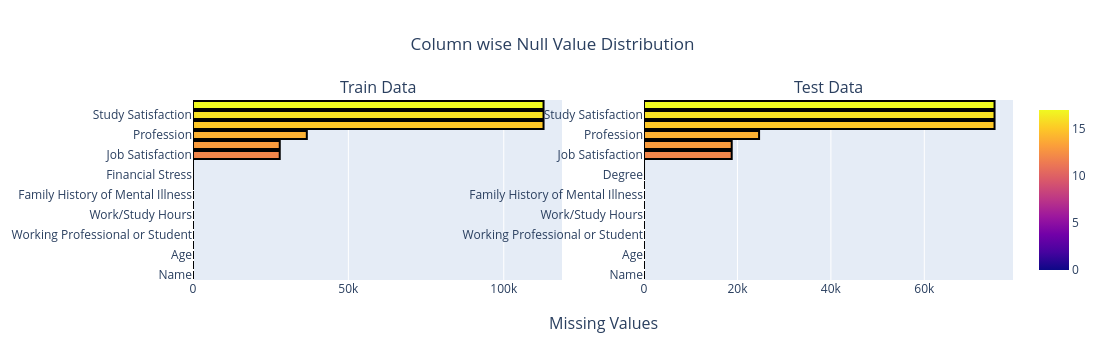

In [26]:
test_null = pd.DataFrame(test.isna().sum())
test_null = test_null.sort_values(by = 0 ,ascending = True)
train_null = pd.DataFrame(train.iloc[:,:-1].isna().sum())
train_null = train_null.sort_values(by = 0 ,ascending = True)


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values")

fig.add_trace(go.Bar(x=train_null[0],
                     y=train_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(18)], 
                                line_color='rgb(0,0,0)' , 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=test_null[0], 
                     y=test_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(18)], 
                                line_color='rgb(0,0,0)', 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 2)

fig.update_layout(showlegend=False, title_text="Column wise Null Value Distribution", title_x=0.5)


### Row wise Null Value Distribution 


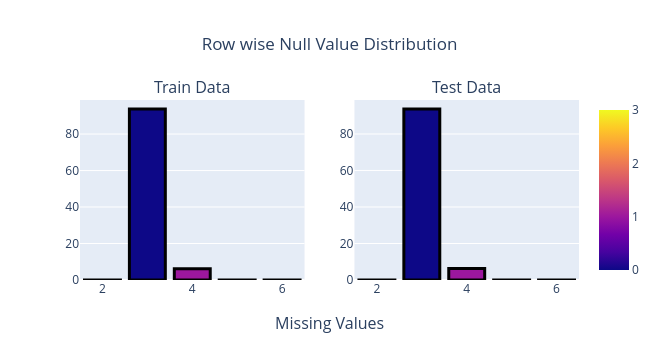

In [14]:
missing_train_row = train.isna().sum(axis=1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/
                                 train.shape[0]).reset_index()
missing_test_row = test.isna().sum(axis=1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()
missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"]*100
missing_test_row["count"] = missing_test_row["count"]*100


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values",)

fig.add_trace(go.Bar(x=missing_train_row["no"], 
                     y=missing_train_row["count"]  ,
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)' ,
                                line_width = 3
                                ,coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x= missing_test_row["no"], 
                     y=missing_test_row["count"],
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)',
                                line_width = 3 ,
                                coloraxis="coloraxis")),
              1, 2)
fig.update_layout(showlegend=False, title_text="Row wise Null Value Distribution", title_x=0.5)

> Dealing with missing value (reference) 
> Some references on how to deal with missing value:
> 
> Missing Values by Alexis Cook
> Data Cleaning Challenge: Handling missing values by Rachael Tatman
> A Guide to Handling Missing values in Python by Parul Pandey
> Some models that have capability to handle missing value by default are:
> 
> XGBoost: https://xgboost.readthedocs.io/en/latest/faq.html
> LightGBM: https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html
> Catboost: https://catboost.ai/docs/concepts/algorithm-missing-values-processing.html

### Continuos and Categorical Data Distribution

Total number of features: 18
Number of categorical features: 10
Number of continuos features: 7
Number of text features: 1


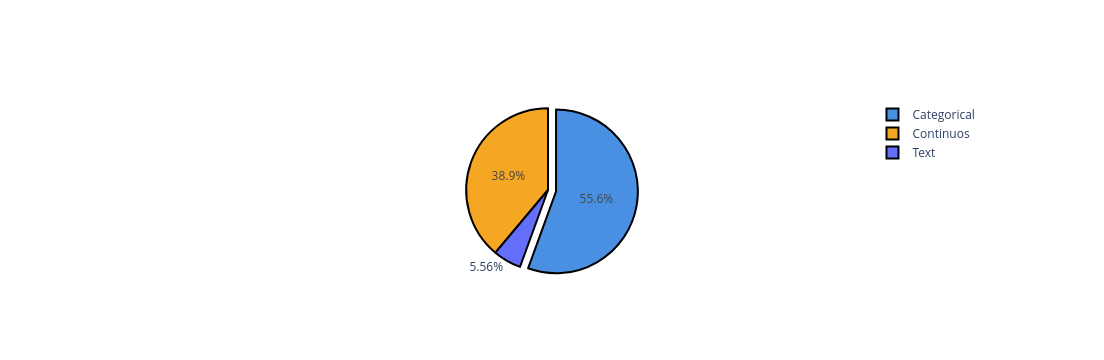

In [15]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis=0)
text_features = [ "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features ]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features ]

del df
print(f'Total number of features: {len(FEATURES)}')
print(f'Number of categorical features: {len(cat_features)}')
print(f'Number of continuos features: {len(cont_features)}')
print(f'Number of text features: {len(text_features)}')

labels=['Categorical', 'Continuos', "Text"]
values= [len(cat_features), len(cont_features), len(text_features)]
colors = ['#4A90E2', '#F5A623']

fig = go.Figure(data=[go.Pie(
    labels=labels, 
    values=values, pull=[0.1, 0, 0 ],
    marker=dict(colors=colors, 
                line=dict(color='#000000', 
                          width=2))
)])
fig.show()

### Feature Distribution of Continous Features 

#### Distribution of Age 

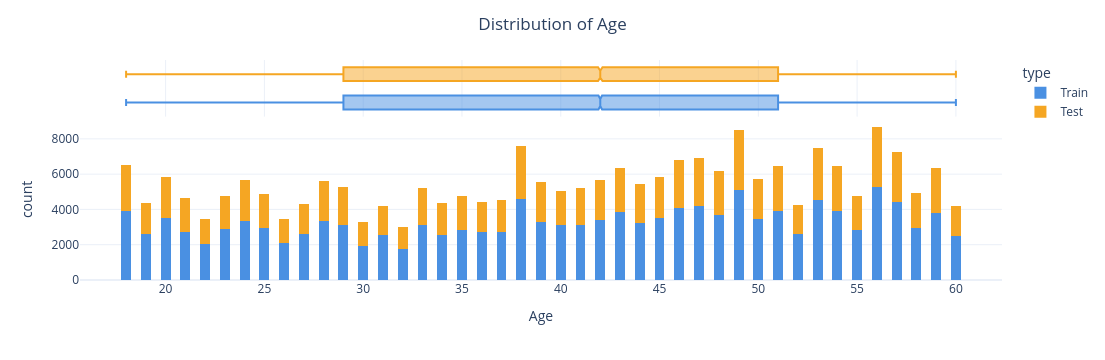

In [16]:
train_age = train.copy()
test_age = test.copy()
train_age["type"] = "Train"
test_age["type"] = "Test"
ageDf = pd.concat([train_age, test_age])
fig = px.histogram(data_frame = ageDf, 
                   x="Age",
                   color= "type",
                   color_discrete_sequence = ['#4A90E2', '#F5A623'],
                   marginal="box",
                   nbins= 100,
                    template="plotly_white"
                )
fig.update_layout(title = "Distribution of Age" , title_x = 0.5)
fig.show()

### Feature Distribution of Categorical Features 

In [ ]:
if len(cat_features) == 0 :
    print("No Categorical features")
else:
    ncols = 2
    nrows = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
    for r in range(nrows):
        for c in range(ncols):
            col = train.select_dtypes(np.number).columns.tolist()[r*ncols+c]
            sns.countplot(train[col],ax = axes[r,c] ,palette = "viridis", label='Train data')
            sns.countplot(test[col],ax = axes[r,c] ,palette = "magma", label='Test data')
            axes[r,c].legend()
            axes[r,c].set_ylabel('')
            axes[r,c].set_xlabel(col, fontsize=20)
            axes[r,c].tick_params(labelsize=10, width=0.5)
            axes[r,c].xaxis.offsetText.set_fontsize(4)
            axes[r,c].yaxis.offsetText.set_fontsize(4)
    plt.show()

In [ ]:
target_df = pd.DataFrame(train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame =target_df, 
             x = TARGET,
             y = 'count'
            ) 
fig.update_traces(marker_color =['#4A90E2', '#F5A623'], 
                  marker_line_color='rgb(0,0,0)',
                  marker_line_width=2,)
fig.update_layout(title = "Target Distribution",
                  template = "plotly_white",
                  title_x = 0.5)
print("Percentage of Depression = 0: {:.2f} %".format(target_df["count"][0] *100 / train.shape[0]))
print("Percentage of Depression = 1: {:.2f} %".format(target_df["count"][1]* 100 / train.shape[0]))
fig.show()


> Observations in Target Value Distribution :
* There are two target values - 0 and 1.
* 81 % Not Depression values and  18 % Depression values.
* The target data imbalanced

### Correlation matrix 

In [ ]:
correlation_matrix = train.select_dtypes(np.number).corr()

# Plotting the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

> Observations Corrolation Features :
* There are many strong corrolation between features as Academic Pressure --> Job Satisfaction --> Job Satisfaction	 
* Depression has corrolation with  Academic Pressure and Work Pressure and Financial Stress	

## Data Pre-Processing


### Rename Columns

In [ ]:
train = train.rename(columns={'Name':'Name',
                         'Gender':'Gender',
                         'Age':'Age',
                         'City':"City",
                         'Working Professional or Student':'WorkingPforSt',
                         'Profession':"Profession",
                         'Academic Pressure':"AcademicP",
                         'Work Pressure':'WorkP',
                         'CGPA':"CGPA",
                         'Study Satisfaction':"StudySatisfaction",
                         'Job Satisfaction':'JobSatisfaction',
                         'Sleep Duration':'SleepDuration',
                         'Dietary Habits':"DietaryHabits",
                         'Degree':"Degree",
                         'Have you ever had suicidal thoughts ?':"SuicidalThoughts",
                         'Work/Study Hours':"SpendHours",
                         'Financial Stress':"FinancialStress",
                         'Family History of Mental Illness':"FamilyMentalIllness",
                         'Depression':"Depression"})
test = test.rename(columns={'Name':'Name',
                         'Gender':'Gender',
                         'Age':'Age',
                         'City':"City",
                         'Working Professional or Student':'WorkingPforSt',
                         'Profession':"Profession",
                         'Academic Pressure':"AcademicP",
                         'Work Pressure':'WorkP',
                         'CGPA':"CGPA",
                         'Study Satisfaction':"StudySatisfaction",
                         'Job Satisfaction':'JobSatisfaction',
                         'Sleep Duration':'SleepDuration',
                         'Dietary Habits':"DietaryHabits",
                         'Degree':"Degree",
                         'Have you ever had suicidal thoughts ?':"SuicidalThoughts",
                         'Work/Study Hours':"SpendHours",
                         'Financial Stress':"FinancialStress",
                         'Family History of Mental Illness':"FamilyMentalIllness",
                         })

#### Imputing Missing Values 

In [ ]:
test['Depression']=0
df=pd.concat([train,test])
cat_train=train.copy()
cat_test=test.copy()


In [ ]:
df['JobSatisfaction'].fillna(0,inplace=True)
df['AcademicP'].fillna(0,inplace=True)
df['StudySatisfaction'].fillna(0,inplace=True)
df['jobacstud']=df['JobSatisfaction']+df["AcademicP"]+df["StudySatisfaction"]

In [ ]:
imputer_cols = ["WorkP","CGPA",'FinancialStress']
imputer = SimpleImputer(strategy=STRATEGY )
imputer.fit(df[imputer_cols])
df[imputer_cols] = imputer.transform(df[imputer_cols])


In [ ]:
df['Profession']=df['Profession'].fillna(df['Profession'].mode()[0])
df['DietaryHabits']=df['DietaryHabits'].fillna(df['DietaryHabits'].mode()[0])
df['Degree']=df['Degree'].fillna(df['Degree'].mode()[0])

### Encoding Categorical Features 

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop=None, sparse=False)

df=df.drop(['Name'],axis=1)
binary_col=["Gender","WorkingPforSt","SuicidalThoughts","FamilyMentalIllness"]
nominal_col=["City","Profession","Degree"]
ordinal_col=['SleepDuration',"DietaryHabits"]
encoded_data = encoder.fit_transform(df[nominal_col])
feature_names = encoder.get_feature_names_out(nominal_col)
encoded_data=pd.DataFrame(encoded_data,columns=feature_names)
df=df.drop(nominal_col,axis=1)
df.reset_index(inplace=True)
df=pd.concat([df,encoded_data],axis=1)
df=df.drop('index',axis=1)

In [ ]:

def label_encoder(df,columns):
    for col in columns:
        df[col] = df[col].astype(str)
        df[col] = LabelEncoder().fit_transform(df[col])
    return df

df = label_encoder(df ,binary_col)

In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoding_maps = {}
    
    def fit(self, X, y=None):
        """
        Aprende el mapeo de frecuencias para las columnas especificadas.
        
        Args:
        X (pd.DataFrame): DataFrame de entrenamiento.
        y: Ignorado (compatibilidad con scikit-learn).

        Returns:
        self
        """
        for column in X.columns:
            freq_encoding = X[column].value_counts() / len(X)
            self.encoding_maps[column] = freq_encoding.to_dict()
        return self

    def transform(self, X):
        """
        Aplica la codificación de frecuencia a las columnas del DataFrame.
        
        Args:
        X (pd.DataFrame): DataFrame a transformar.

        Returns:
        pd.DataFrame: DataFrame transformado.
        """
        X_transformed = X.copy()
        for column in X.columns:
            encoding_map = self.encoding_maps.get(column, {})
            X_transformed[column] = X_transformed[column].map(lambda x: encoding_map.get(x, -1))
        return X_transformed

In [ ]:
# Encoding by frequency
encoder = FrequencyEncoder()
encoder.fit(df[ordinal_col])
df[ordinal_col] = encoder.transform(df[ordinal_col])
print('Encoding done!')

In [ ]:
train=df[:train.shape[0]]
test=df[train.shape[0]:]
test=test.drop('Depression',axis=1)
del df
gc.collect()

In [ ]:
train.isna().sum().sum(),test.isna().sum().sum()

In [30]:
train.head()

Gender   Age  WorkingPforSt  AcademicP  WorkP  CGPA  StudySatisfaction  \
0       0 49.00              1       0.00   5.00  7.77               0.00   
1       1 26.00              1       0.00   4.00  7.77               0.00   
2       1 33.00              0       5.00   3.00  8.97               2.00   
3       1 22.00              1       0.00   5.00  7.77               0.00   
4       0 30.00              1       0.00   1.00  7.77               0.00   

   JobSatisfaction  SleepDuration  DietaryHabits  ...  Degree_S.Pharm  \
0             2.00           0.23           0.32  ...            0.00   
1             3.00           0.27           0.33  ...            0.00   
2             0.00           0.23           0.32  ...            0.00   
3             1.00           0.27           0.35  ...            0.00   
4             1.00           0.23           0.33  ...            0.00   

   Degree_S.Tech  Degree_Travel Consultant  Degree_UX/UI Designer  \
0           0.00                      0.00                   0.00   
1           0.00                      0.00                   0.00   
2           0.00                      0.00                   0.00   
3           0.00                      0.00                   0.00   
4           0.00                      0.00                   0.00   

   Degree_Unite  Degree_Veda  Degree_Vibha  Degree_Vivaan  Degree_Vrinda  \
0          0.00         0.00          0.00           0.00           0.00   
1          0.00         0.00          0.00           0.00           0.00   
2          0.00         0.00          0.00           0.00           0.00   
3          0.00         0.00          0.00           0.00           0.00   
4          0.00         0.00          0.00           0.00           0.00   

   Degree_Working Professional  
0                         0.00  
1                         0.00  
2                         0.00  
3                         0.00  
4                         0.00  

[5 rows x 377 columns]

In [31]:
test.head()

Gender   Age  WorkingPforSt  AcademicP  WorkP  CGPA  \
140700       1 53.00              1       0.00   2.00  7.77   
140701       0 58.00              1       0.00   2.00  7.77   
140702       1 53.00              1       0.00   4.00  7.77   
140703       0 23.00              0       5.00   3.00  6.84   
140704       1 47.00              1       0.00   5.00  7.77   

        StudySatisfaction  JobSatisfaction  SleepDuration  DietaryHabits  ...  \
140700               0.00             5.00           0.27           0.35  ...   
140701               0.00             4.00           0.27           0.35  ...   
140702               0.00             1.00           0.26           0.35  ...   
140703               1.00             0.00           0.23           0.35  ...   
140704               0.00             5.00           0.26           0.35  ...   

        Degree_S.Pharm  Degree_S.Tech  Degree_Travel Consultant  \
140700            0.00           0.00                      0.00   
140701            0.00           0.00                      0.00   
140702            0.00           0.00                      0.00   
140703            0.00           0.00                      0.00   
140704            0.00           0.00                      0.00   

        Degree_UX/UI Designer  Degree_Unite  Degree_Veda  Degree_Vibha  \
140700                   0.00          0.00         0.00          0.00   
140701                   0.00          0.00         0.00          0.00   
140702                   0.00          0.00         0.00          0.00   
140703                   0.00          0.00         0.00          0.00   
140704                   0.00          0.00         0.00          0.00   

        Degree_Vivaan  Degree_Vrinda  Degree_Working Professional  
140700           0.00           0.00                         0.00  
140701           0.00           0.00                         0.00  
140702           0.00           0.00                         0.00  
140703           0.00           0.00                         0.00  
140704           0.00           0.00                         0.00  

[5 rows x 376 columns]

## Modeling

In [32]:
X = train.drop(TARGET , axis =1 )
y = train[TARGET]
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 2024 ,
                                                       test_size =0.33)

### 29 Different Classifiers ( LAZY PREDICT )

In [33]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=2024,
                     classifiers='all')

models, predictions = clf.fit(X_train[:100_00] , X_test[:100_00] , y_train[:100_00] , y_test[:100_00])
# clear_output()

 97%|█████████▋| 28/29 [00:48<00:02,  2.41s/it]

[LightGBM] [Info] Number of positive: 1799, number of negative: 8201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.179900 -> initscore=-1.517025
[LightGBM] [Info] Start training from score -1.517025


100%|██████████| 29/29 [00:49<00:00,  1.70s/it]


### Visualizing Results 


In [34]:
models[:15]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                         
LGBMClassifier                   0.93               0.88     0.88      0.93   
AdaBoostClassifier               0.93               0.88     0.88      0.93   
LinearSVC                        0.93               0.88     0.88      0.93   
LogisticRegression               0.93               0.88     0.88      0.93   
XGBClassifier                    0.93               0.88     0.88      0.93   
CalibratedClassifierCV           0.93               0.88     0.88      0.93   
SGDClassifier                    0.92               0.87     0.87      0.92   
LinearDiscriminantAnalysis       0.93               0.86     0.86      0.93   
SVC                              0.93               0.86     0.86      0.93   
BaggingClassifier                0.93               0.86     0.86      0.93   
PassiveAggressiveClassifier      0.91               0.86     0.86      0.91   
RandomForestClassifier           0.93               0.85     0.85      0.93   
Perceptron                       0.91               0.85     0.85      0.91   
ExtraTreesClassifier             0.93               0.85     0.85      0.92   
DecisionTreeClassifier           0.90               0.84     0.84      0.90   

                             Time Taken  
Model                                    
LGBMClassifier                     0.51  
AdaBoostClassifier                 1.70  
LinearSVC                          2.13  
LogisticRegression                 0.52  
XGBClassifier                      1.21  
CalibratedClassifierCV             7.75  
SGDClassifier                      0.81  
LinearDiscriminantAnalysis         0.68  
SVC                               11.35  
BaggingClassifier                  0.97  
PassiveAggressiveClassifier        0.38  
RandomForestClassifier             1.78  
Perceptron                         0.35  
ExtraTreesClassifier               2.05  
DecisionTreeClassifier             0.33

In [35]:
line = px.line(data_frame= models ,y =["Accuracy"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Accuracy")
line.update_traces(line_color="red")
line.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

In [36]:
line = px.line(data_frame= models ,y =["ROC AUC" , "F1 Score"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "ROC AUC SCORE")
line.update_layout(showlegend = True,
    title = {
        'text': 'ROC AUC and F1 Score vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

In [37]:
line = px.line(data_frame= models ,y =["Time Taken"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Time(s)")
line.update_traces(line_color="purple")
line.update_layout(showlegend = True,
    title = {
        'text': 'TIME TAKEN vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

## LGBM Classifier(10 FOLDS) 

In [38]:
lgb_params = {
    'tree_depth':3,
    'min_n':13,
    'loss_reduction':0.04481981,
    'mtry':12,
    'num_leaves':152,
    'objective' : 'binary',
    'n_estimators' :50,
    'learning_rate' :0.6103077,
    'feature_fraction': 0.824727327666877,
    'bagging_fraction': 0.584271177810496,
     'verbosity': -1,

}

lgb_predictions = 0
lgb_scores = []
lgb_fimp = []
LGBM_FEATURES = list(train.drop('Depression',axis=1).columns)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[LGBM_FEATURES], train[TARGET])):
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][LGBM_FEATURES], train.iloc[valid_idx][LGBM_FEATURES]
    y_train , y_valid = train[TARGET].iloc[train_idx] , train[TARGET].iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train)
    
    preds_valid = model.predict(X_valid)
    acc = accuracy_score(y_valid,  preds_valid)
    lgb_scores.append(acc)
    run_time = time.time() - start_time
    
    fim = pd.DataFrame(index=LGBM_FEATURES,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    
    print(f"Fold={fold+1}, Accuracy score: {acc:.2f}%, Run Time: {run_time:.2f}s")
    test_preds = model.predict(test[LGBM_FEATURES]) 
    lgb_predictions += test_preds/FOLDS
print("")
print("Mean Accuracy :", np.mean(lgb_scores))


========== Fold=1 ==========
Fold=1, Accuracy score: 0.93%, Run Time: 2.01s
========== Fold=2 ==========
Fold=2, Accuracy score: 0.92%, Run Time: 2.02s
========== Fold=3 ==========
Fold=3, Accuracy score: 0.92%, Run Time: 2.01s
========== Fold=4 ==========
Fold=4, Accuracy score: 0.93%, Run Time: 2.02s
========== Fold=5 ==========
Fold=5, Accuracy score: 0.92%, Run Time: 2.00s
========== Fold=6 ==========
Fold=6, Accuracy score: 0.91%, Run Time: 2.03s
========== Fold=7 ==========
Fold=7, Accuracy score: 0.93%, Run Time: 2.16s
========== Fold=8 ==========
Fold=8, Accuracy score: 0.93%, Run Time: 2.00s
========== Fold=9 ==========
Fold=9, Accuracy score: 0.93%, Run Time: 2.04s
========== Fold=10 ==========
Fold=10, Accuracy score: 0.93%, Run Time: 2.00s

Mean Accuracy : 0.925138592750533


In [39]:
cat_test=cat_test.drop('Depression',axis=1)

In [40]:
cat_train.isna().sum()

Name                        0
Gender                      0
Age                         0
City                        0
WorkingPforSt               0
Profession              36630
AcademicP              112803
WorkP                   27918
CGPA                   112802
StudySatisfaction      112803
JobSatisfaction         27910
SleepDuration               0
DietaryHabits               4
Degree                      2
SuicidalThoughts            0
SpendHours                  0
FinancialStress             4
FamilyMentalIllness         0
Depression                  0
dtype: int64

In [41]:
for df2 in [cat_train,cat_test]:
    for col in ['AcademicP',"WorkP","CGPA","StudySatisfaction","JobSatisfaction",'Age','SpendHours','FinancialStress']:
        df2[col] = df2[col].apply(lambda x: 'missing' if  pd.isna(x) else int(x) )


In [42]:
cat_train.fillna('missing',inplace=True)
cat_test.fillna('missing',inplace=True)


In [43]:
y_cat = cat_train['Depression']
X_cat = cat_train.drop(['Depression'],axis=1)

In [44]:
params = {'loss_function': 'Logloss',
           'eval_metric': 'AUC',
           'learning_rate': 0.08114394459649094,
           'iterations': 1000,
           'depth': 6,
           'random_strength':0,
           'l2_leaf_reg': 0.7047064221215757,
#            'task_type': 'GPU'
         } 


def CAT_(test, catboost_params):

    SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
    train_accuracies = []
    valid_accuracies = []
    test_predictions = []
    oof_predictions = np.zeros(len(X_cat))
    
    test_pool = Pool(cat_test, cat_features=X_cat.columns.values)
    
    for fold, (train_idx, val_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X_cat.iloc[train_idx], X_cat.iloc[val_idx]
        y_train, y_val = y_cat.iloc[train_idx], y_cat.iloc[val_idx]
        
        train_pool = Pool(X_train, y_train, cat_features=X_cat.columns.values)
        val_pool = Pool(X_val, y_val, cat_features=X_cat.columns.values)
        
        model = CatBoostClassifier(**catboost_params, random_state=2024, verbose=0)
        model.fit(X=train_pool, eval_set=val_pool, early_stopping_rounds=50)
        
        train_predictions = model.predict(train_pool)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_accuracies.append(train_accuracy)
        
        val_predictions = model.predict(val_pool)
        valid_accuracy = accuracy_score(y_val, val_predictions)
        valid_accuracies.append(valid_accuracy)
        
        oof_predictions[val_idx] = model.predict_proba(val_pool)[:, 1]
        
        test_fold_pred = model.predict_proba(test_pool)[:, 1]
        test_predictions.append(test_fold_pred)
        
        print(f'Fold {fold + 1} Train Accuracy: {train_accuracy:.3f}, Valid Accuracy: {valid_accuracy:.3f}')
        clear_output(wait=True)

    overall_train_accuracy = np.mean(train_accuracies)
    overall_valid_accuracy = np.mean(valid_accuracies)
    print(f'Overall Train Accuracy: {overall_train_accuracy:.3f}')
    print(f'Overall Valid Accuracy: {overall_valid_accuracy:.3f}')
    
    mean_oof_preds = np.mean(oof_predictions)
    mean_test_preds = np.mean(test_predictions, axis=0)
    
    return mean_oof_preds, mean_test_preds


meanOFF, meanTest = CAT_(cat_test,params)


Overall Train Accuracy: 0.947
Overall Valid Accuracy: 0.940


## Feature Importance 

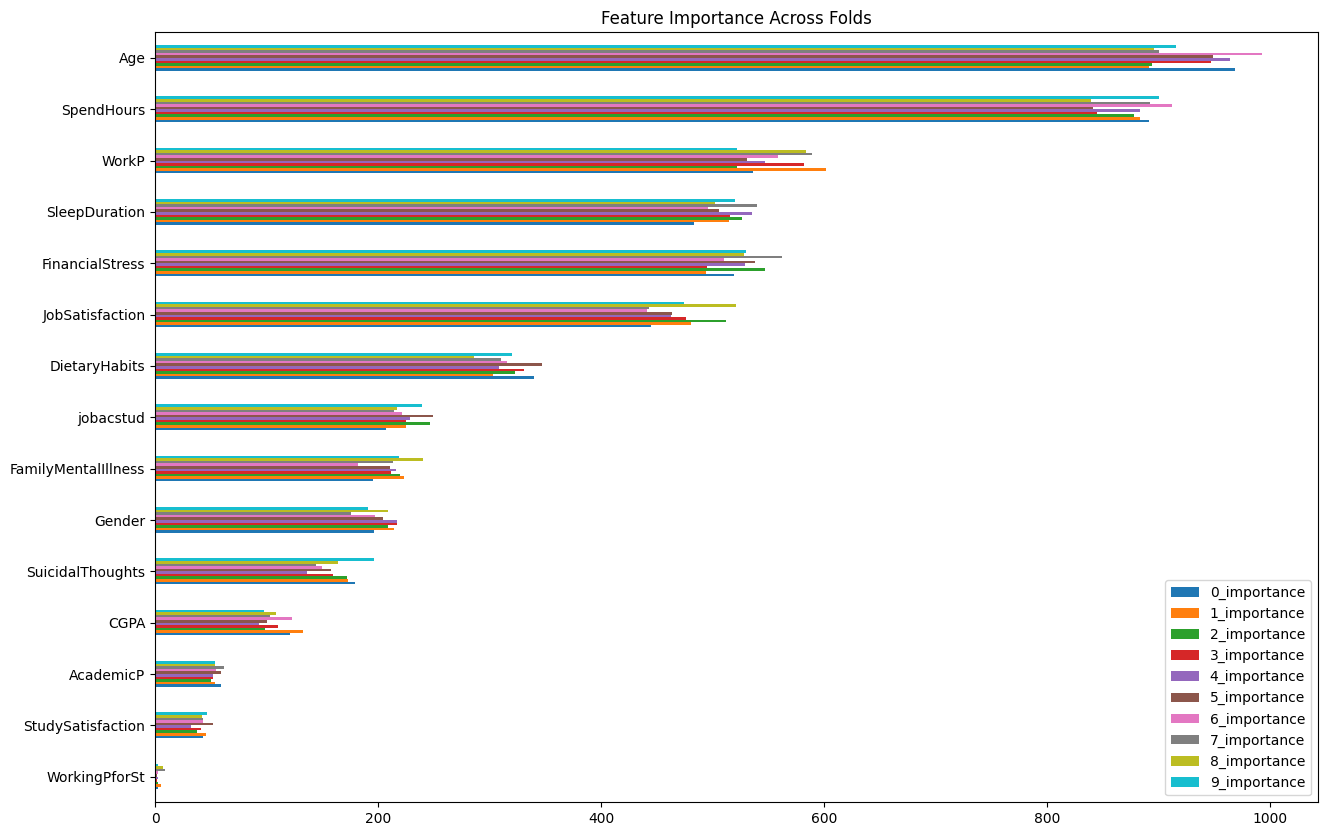

In [45]:
lgbm_fis_df = pd.concat(lgb_fimp, axis=1).head(15)
lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10),
                                       title='Feature Importance Across Folds')
plt.show()

In [46]:
# https://www.kaggle.com/code/adyiemaz/this-code-fixed-my-depression
from xgboost import XGBClassifier

paramsxgb={'colsample_bytree': 0.288807006380292,
             'n_estimators': 687,
             'learning_rate': 0.07530305446753063,
             'reg_lambda': 0.7430403624711,
             'reg_alpha': 0.3037629135788351, 
             'max_depth': 4, 
             'gamma': 0.08745985967670639}

def XGB_(test, paramsxgb):

    SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
    train_accuracies = []
    valid_accuracies = []
    test_predictions = []
    oof_predictions = np.zeros(len(X))    
    for fold, (train_idx, val_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]        
        model=XGBClassifier(**paramsxgb,
                        eval_metric='auc',
                        random_state=2024
                        )
        eval_set = [(X_train, y_train), (X_test, y_test)]
        model.fit(X_train,y_train,eval_set=eval_set,verbose=False)
        
        train_predictions = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_accuracies.append(train_accuracy)
        
        val_predictions = model.predict(X_val)
        valid_accuracy = accuracy_score(y_val, val_predictions)
        valid_accuracies.append(valid_accuracy)
        
        oof_predictions[val_idx] = model.predict_proba(X_val)[:, 1]
        
        test_fold_pred = model.predict_proba(test)[:, 1]
        test_predictions.append(test_fold_pred)
        
        print(f'Fold {fold + 1} Train Accuracy: {train_accuracy:.3f}, Valid Accuracy: {valid_accuracy:.3f}')
        clear_output(wait=True)

    overall_train_accuracy = np.mean(train_accuracies)
    overall_valid_accuracy = np.mean(valid_accuracies)
    print(f'Overall Train Accuracy: {overall_train_accuracy:.3f}')
    print(f'Overall Valid Accuracy: {overall_valid_accuracy:.3f}')
    
    mean_oof_preds = np.mean(oof_predictions)
    mean_test_preds = np.mean(test_predictions, axis=0)
    
    return mean_oof_preds, mean_test_preds


meanOFFX, meanTestX = XGB_(test,paramsxgb)


Overall Train Accuracy: 0.945
Overall Valid Accuracy: 0.940


## Submission

### LGBM Classifier Submission

In [47]:
y_oof = 0.1*lgb_predictions + 0.2*meanTest + 0.7*meanTestX
# y_oof_binary = (y_oof >= np.percentile(lgb_predictions, 80)).astype(int)
submission[TARGET] = y_oof
submission[TARGET] = submission[TARGET].apply(lambda x: 1 if x> 0.5 else 0)

submission.to_csv("submission.csv",index=False)
submission.head()


id  Depression
0  140700           0
1  140701           0
2  140702           0
3  140703           1
4  140704           0

## References


* I took of the inspiration from the following notebooks

* [🚀 Spaceship Titanic: A complete guide 🏆](https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide) by [Samuel Cortinhas ](https://www.kaggle.com/samuelcortinhas)

* [🚀Spaceship Titanic -📊EDA + 27 different models📈](https://www.kaggle.com/code/odins0n/spaceship-titanic-eda-27-different-models) by [Sanskar Hasija](https://www.kaggle.com/odins0n)

* [LGBM Got Mentally Depressed | R](https://www.kaggle.com/code/khsamaha/lgbm-got-mentally-depressed-r) by [Kheirallah Samaha ](https://www.kaggle.com/khsamaha)

* [Mental health | EDA| Catcoost| LGBM](https://www.kaggle.com/code/javohirtoshqorgonov/mental-health-eda-catcoost-lgbm) by [Javohir Toshqurgonov ](https://www.kaggle.com/javohirtoshqorgonov)